In [37]:
library(tidyverse, verbose = FALSE)
library(lubridate, verbose = FALSE)
library(forecast, verbose = FALSE)
library(car, verbose = FALSE)
library(boot, verbose = FALSE)
library(zoo, verbose = FALSE)
library(ggplot2, verbose = FALSE)
library(factoextra, verbose = FALSE)
cities <- c(
  "New York", "Los Angeles", "Chicago", "Houston", "Phoenix",
  "Philadelphia", "San Antonio", "San Diego", "Dallas", "San Jose"
)
set.seed(5100)

# Load Pollutant Data

In [38]:
pm25_raw <- read_csv("../../data/daily_88101_2023.csv", show_col_types = FALSE)
o3_raw   <- read_csv("../../data/daily_44201_2023.csv", show_col_types = FALSE)
no2_raw  <- read_csv("../../data/daily_42602_2023.csv", show_col_types = FALSE)

clean_pollutant <- function(df, pollutant_name) {
  df %>%
    filter(`City Name` %in% cities) %>%          # filter ROWS by city name
    mutate(Date = ymd(`Date Local`)) %>%         # convert date
    select(`City Name`, Date, `Arithmetic Mean`) %>%  # select correct columns
    rename(
      City = `City Name`,
      !!pollutant_name := `Arithmetic Mean`
    )
} 

pm25 <- clean_pollutant(pm25_raw, "PM25")
o3   <- clean_pollutant(o3_raw,   "O3")
# Convert o3 from ppm to ppb
o3 <- o3 %>%
  mutate(O3 = O3 * 1000)
no2  <- clean_pollutant(no2_raw,  "NO2")

air_df <- pm25 %>%
  inner_join(o3, by = c("City", "Date")) %>%
  inner_join(no2, by = c("City", "Date"))

# There are duplicate rows as the indicators have multiple monitoring sites per city. 
air_df_clean <- air_df %>%
  group_by(City, Date) %>%
  summarise(
    PM25 = mean(PM25, na.rm = TRUE),
    O3   = mean(O3,   na.rm = TRUE),
    NO2  = mean(NO2,  na.rm = TRUE),
    .groups = "drop"
  ) %>%
  arrange(City, Date)

head(air_df_clean)

Warning message in inner_join(., o3, by = c("City", "Date")):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 12 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”
Warning message in inner_join(., no2, by = c("City", "Date")):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 12 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


City,Date,PM25,O3,NO2
<chr>,<date>,<dbl>,<dbl>,<dbl>
Chicago,2023-03-01,9.166667,26.43133,15.797916
Chicago,2023-03-02,2.800000,36.49033,9.470833
Chicago,2023-03-04,16.100000,21.09800,19.579167
Chicago,2023-03-07,3.150000,38.09800,6.368750
Chicago,2023-03-10,3.300000,33.85300,10.012500
Chicago,2023-03-13,4.175000,32.26450,11.920265


## Load Weather Data

In [39]:
# load weather data for all cities
city_weather_dfs <- list()
for (city in cities) {
    df <- read_csv(paste0("../../data/weather_data/", city, ".csv"), show_col_types = FALSE)

    # mutate date to not have time component
    df <- df %>%
      mutate(date = as.Date(date))

    city_weather_dfs[[city]] <- df
}

head(city_weather_dfs[["New York"]] )

date,cloud_cover_mean,relative_humidity_2m_mean,wind_gusts_10m_mean,wind_speed_10m_mean,precipitation_hours,precipitation_sum,temperature_2m_mean
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2023-01-01,42.54167,82.91020,13.682983,7.770374,2,0.04330709,47.62655
2023-01-02,86.04166,84.02973,7.372779,4.012463,3,0.02362205,46.17905
2023-01-03,99.79166,96.86331,11.063829,6.264936,8,0.37007874,49.25780
2023-01-04,99.33334,94.22936,12.014553,6.537843,5,0.09055118,55.35905
2023-01-05,96.75000,92.18182,9.535212,5.195051,0,0.00000000,49.65530
2023-01-06,66.62500,85.81839,11.352776,6.153474,14,0.37795272,42.60155


## New York City Only

### Shapiro Test - Check Normality

In [40]:
merge_weather_air <- function(city) {
  df <- city_weather_dfs[[city]]
  df <- df %>%
    inner_join(air_df_clean %>% filter(City == city), by = c("date" = "Date")) %>%
    select(date, temperature_2m_mean, cloud_cover_mean, relative_humidity_2m_mean, wind_gusts_10m_mean, wind_speed_10m_mean, precipitation_hours, precipitation_sum, PM25, O3, NO2)
  return(df)
}

# merge NY weather and air data
ny_df <- merge_weather_air("New York")

# check for missing values
colSums(is.na(ny_df))

# check if temperature is normally distributed
shapiro.test(ny_df$temperature_2m_mean)
shapiro.test(ny_df$PM25)
shapiro.test(ny_df$O3)
shapiro.test(ny_df$NO2)

date       temperature_2m_mean          cloud_cover_mean 
                        0                         0                         0 
relative_humidity_2m_mean       wind_gusts_10m_mean       wind_speed_10m_mean 
                        0                         0                         0 
      precipitation_hours         precipitation_sum                      PM25 
                        0                         0                         0 
                       O3                       NO2 
                        0                         0


	Shapiro-Wilk normality test

data:  ny_df$temperature_2m_mean
W = 0.95826, p-value = 1.13e-08



	Shapiro-Wilk normality test

data:  ny_df$PM25
W = 0.35725, p-value < 2.2e-16



	Shapiro-Wilk normality test

data:  ny_df$O3
W = 0.9962, p-value = 0.5344



	Shapiro-Wilk normality test

data:  ny_df$NO2
W = 0.91849, p-value = 3.576e-13


Temperature data, PM2.5, and NO3 data are not normally distributed, as the Shapiro Wilk normality test has a very low p-value for both variables. Therefore, we reject the null hypothesis that the data is normally distributed.

However, O3 data appears to be normally distributed, as the Shapiro Wilk normality test has a high p-value. Therefore, we fail to reject the null hypothesis that the data is normally distributed.

The approach is to split the temperature data into two groups -- high and low, based on the median temperature of the entire year. Then, we compare the PM2.5 levels between these two groups using the Wilcoxon rank-sum test.

### Pollutant Plots

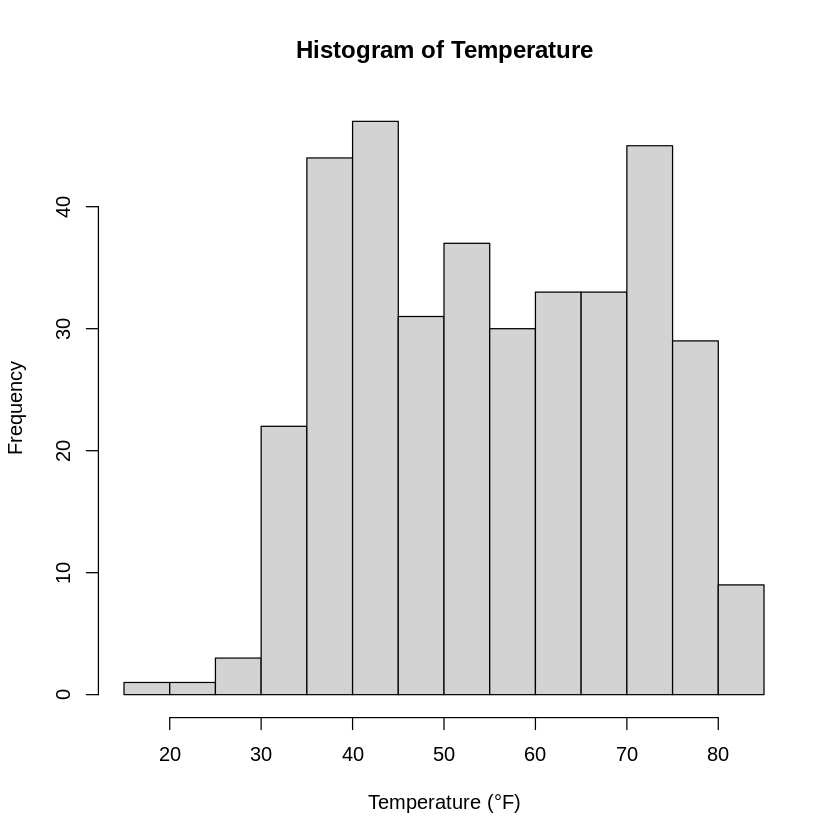

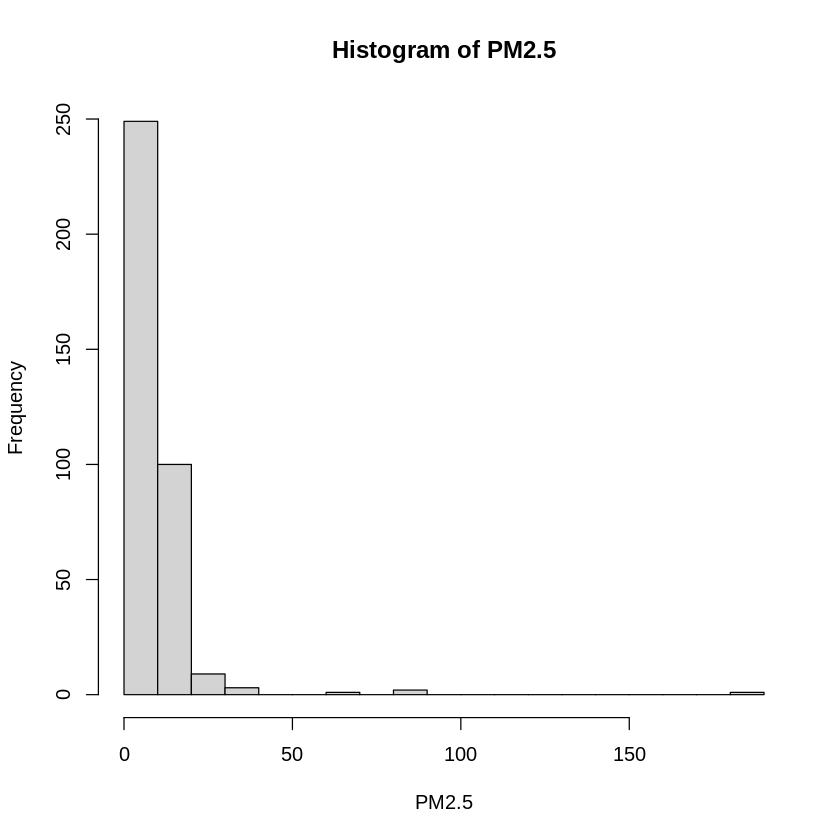

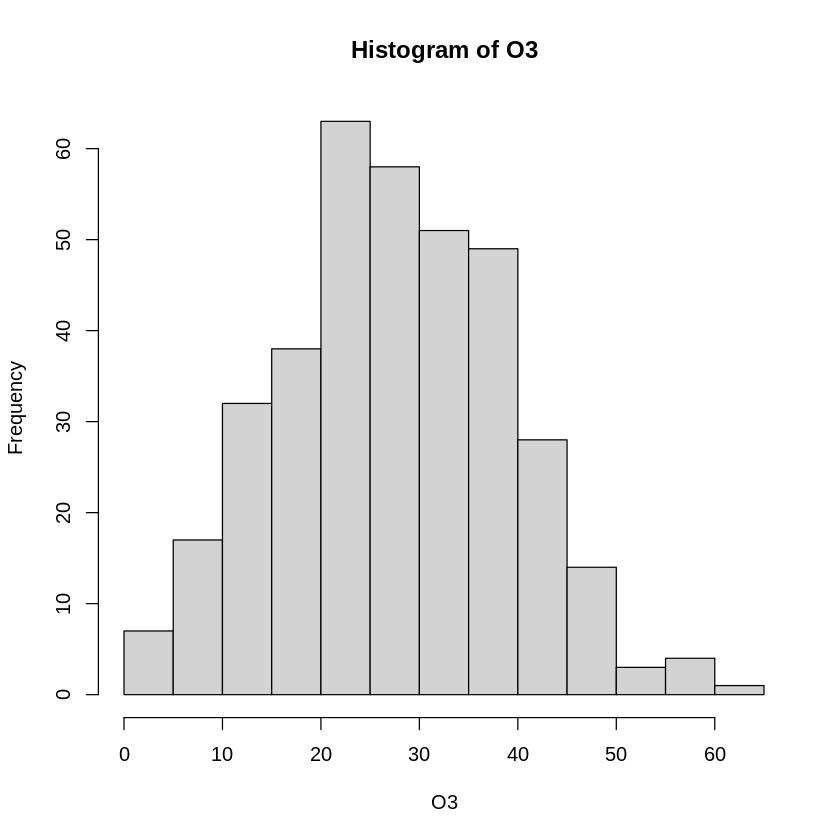

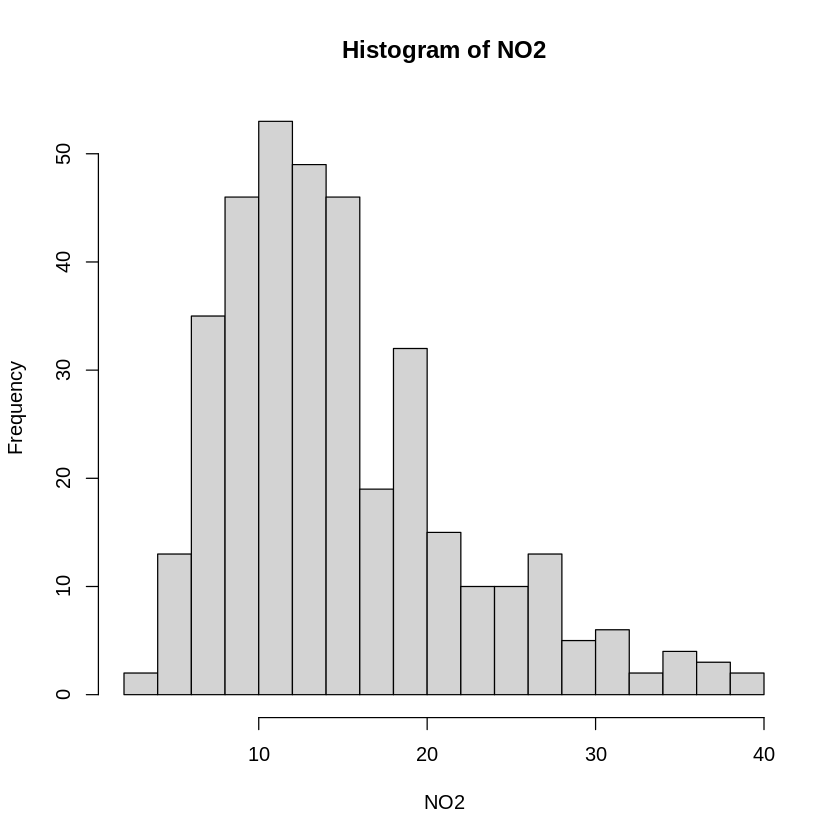

In [41]:
hist(ny_df$temperature_2m_mean, main = "Histogram of Temperature", xlab = "Temperature (°F)", breaks = 20)
hist(ny_df$PM25, main = "Histogram of PM2.5", xlab = "PM2.5", breaks = 20)
hist(ny_df$O3, main = "Histogram of O3", xlab = "O3", breaks = 20)
hist(ny_df$NO2, main = "Histogram of NO2", xlab = "NO2", breaks = 20) 

### Wilcoxon Rank-Sum Test

In [57]:
ny_df <- ny_df %>% filter(between(PM25, quantile(PM25, 0.05, na.rm = TRUE), quantile(PM25, 0.95, na.rm = TRUE))) 

median_temp <- median(ny_df$temperature_2m_mean, na.rm = TRUE)
ny_df$high_temp <- ny_df$temperature_2m_mean > median_temp
print(ny_df$high_temp)

wilcox.test(PM25 ~ high_temp, data = ny_df, conf.int = TRUE)
t.test(O3 ~ high_temp, data = ny_df, conf.int = TRUE)
wilcox.test(NO2 ~ high_temp, data = ny_df, conf.int = TRUE)

  [1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [25] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [37] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [49] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE
 [61] FALSE FALSE  TRUE FALSE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE
 [73]  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE  TRUE  TRUE
 [85]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [97]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[109]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[121]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[133]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[145]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRU


	Wilcoxon rank sum test with continuity correction

data:  PM25 by high_temp
W = 4771, p-value = 0.07354
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 -0.9817890  0.0424708
sample estimates:
difference in location 
            -0.4416517 



	Welch Two Sample t-test

data:  O3 by high_temp
t = -7.6644, df = 208.22, p-value = 6.721e-13
alternative hypothesis: true difference in means between group FALSE and group TRUE is not equal to 0
95 percent confidence interval:
 -12.348126  -7.295442
sample estimates:
mean in group FALSE  mean in group TRUE 
           22.37202            32.19380 



	Wilcoxon rank sum test with continuity correction

data:  NO2 by high_temp
W = 9373, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 5.414220 8.108461
sample estimates:
difference in location 
              6.797175 


The p value of the Wilcoxon rank-sum test is very small, and we therefore conclude that there is a significant difference in PM2.5, O3, and NO2 levels between high and low temperature days in New York City. We now use bootstrapping to confirm our results.

### Bootstrapping

#### PM2.5

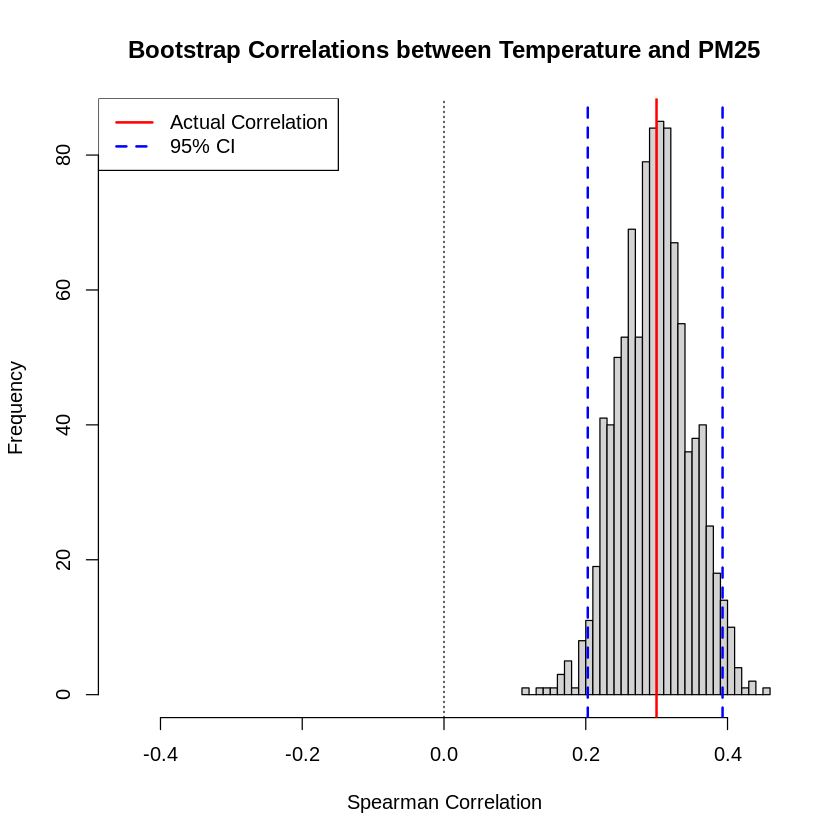

In [53]:
bootstrap <- function(df, pollutant, b){
  bootstrap_correlations <- numeric(b)
  for (i in 1:b){
    sample <- df[sample(nrow(df), replace = TRUE), ]
    bootstrap_correlations[i] <- cor(sample$temperature_2m_mean, sample[[pollutant]], method = "spearman")
  }

  # actual correlation between pollutant and temperature
  actual_correlation <- cor(df$temperature_2m_mean, df[[pollutant]], method = "spearman")

  # 95% confidence interval
  ci <- quantile(bootstrap_correlations, c(0.025, 0.975))

  round(actual_correlation, 3)
  round(ci, 3)
  
  # plot histogram of bootstrap correlations and mark actual correlation and confidence intervals
  m <- max(abs(c(bootstrap_correlations, actual_correlation, ci)))
  hist(bootstrap_correlations, main = paste("Bootstrap Correlations between Temperature and", pollutant), xlab = "Spearman Correlation", breaks = 30, xlim = c(-m, m))
  abline(v = actual_correlation, col = "red", lwd = 2)
  abline(v = ci[1], col = "blue", lwd = 2, lty = 2)
  abline(v = ci[2], col = "blue", lwd = 2, lty = 2)
  abline(v = 0, col = "black", lwd = 1, lty = 3)
  legend("topleft", legend = c("Actual Correlation", "95% CI"), col = c("red", "blue"), lwd = 2, lty = c(1,2))
  }

bootstrap(ny_df, "PM25", 1000)

#### O3

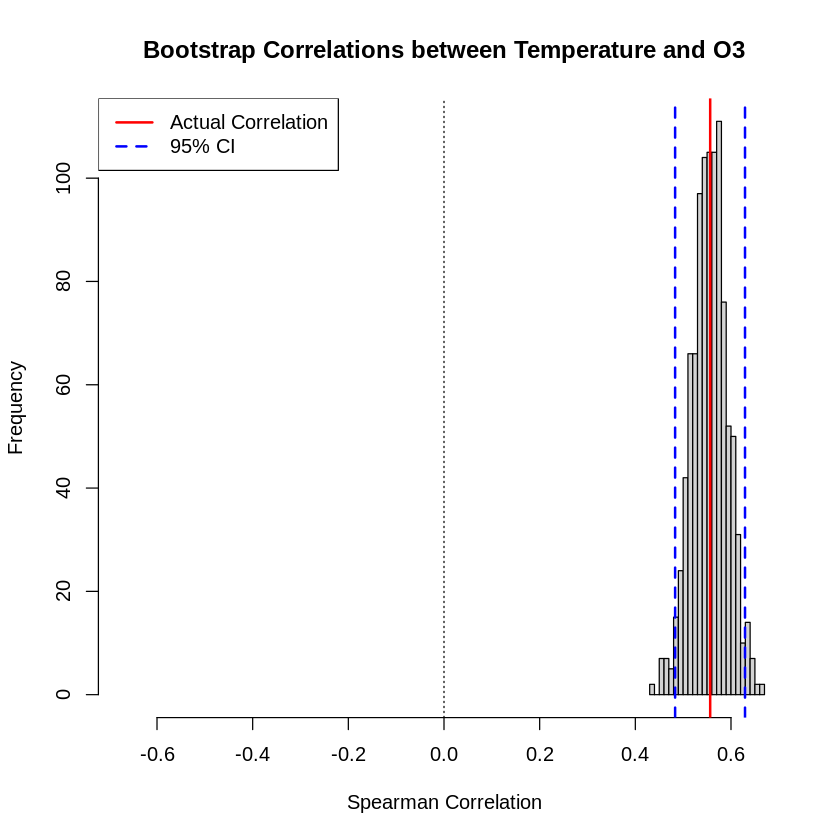

In [44]:
bootstrap(ny_df, "O3", 1000)

#### NO2

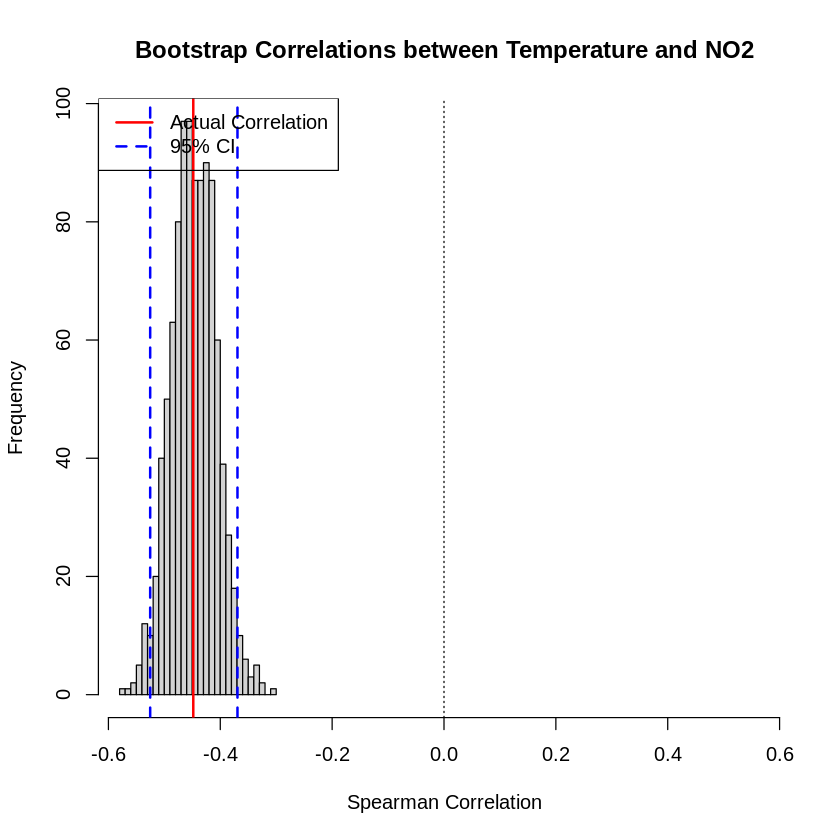

In [45]:
bootstrap(ny_df, "NO2", 1000)

### Data Visualization


In [46]:
merge_weather_air <- function(city) {
  df <- city_weather_dfs[[city]]
  df <- df %>%
    inner_join(air_df_clean %>% filter(City == city), by = c("date" = "Date")) %>%
    select(date, temperature_2m_mean, cloud_cover_mean, relative_humidity_2m_mean, wind_gusts_10m_mean, wind_speed_10m_mean, precipitation_hours, precipitation_sum, PM25, O3, NO2)
  return(df)
}

total_df <- data.frame()
for (city in cities) {
    df <- merge_weather_air(city)
    total_df <- rbind(total_df, df)
}

## add temp high column
median_temp_all <- median(total_df$temperature_2m_mean, na.rm = TRUE)
total_df$high_temp <- total_df$temperature_2m_mean > median_temp_all

Repeat all the same analysis as with New York City 

## All Cities

### Shapiro Test - Check Normality

In [47]:
shapiro.test(total_df$temperature_2m_mean)
shapiro.test(total_df$PM25)
shapiro.test(total_df$O3)
shapiro.test(total_df$NO2)


	Shapiro-Wilk normality test

data:  total_df$temperature_2m_mean
W = 0.99458, p-value = 7.66e-10



	Shapiro-Wilk normality test

data:  total_df$PM25
W = 0.53658, p-value < 2.2e-16



	Shapiro-Wilk normality test

data:  total_df$O3
W = 0.9978, p-value = 0.0001036



	Shapiro-Wilk normality test

data:  total_df$NO2
W = 0.93596, p-value < 2.2e-16


When concatenating data from all cities, we find that temperature and all three pollutants are not normally distributed. 

### Wilcoxon Rank-Sum Test

### PM2.5

In [48]:
wilcox.test(total_df$PM25 ~ total_df$high_temp, conf.int = TRUE)
wilcox.test(total_df$O3 ~ total_df$high_temp, conf.int = TRUE)
wilcox.test(total_df$NO2 ~ total_df$high_temp, conf.int = TRUE)


	Wilcoxon rank sum test with continuity correction

data:  total_df$PM25 by total_df$high_temp
W = 1048592, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 -2.212012 -1.640652
sample estimates:
difference in location 
             -1.924411 



	Wilcoxon rank sum test with continuity correction

data:  total_df$O3 by total_df$high_temp
W = 790472, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 -8.778133 -7.411710
sample estimates:
difference in location 
             -8.088546 



	Wilcoxon rank sum test with continuity correction

data:  total_df$NO2 by total_df$high_temp
W = 1893656, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 3.062450 3.857343
sample estimates:
difference in location 
              3.458981 


### Pollutant Plots 


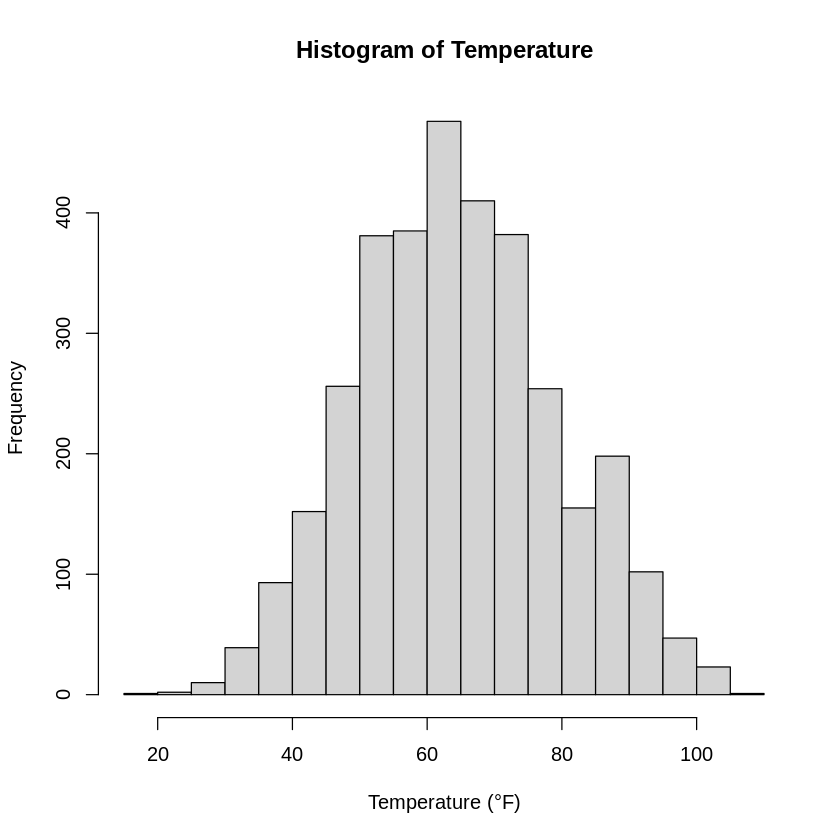

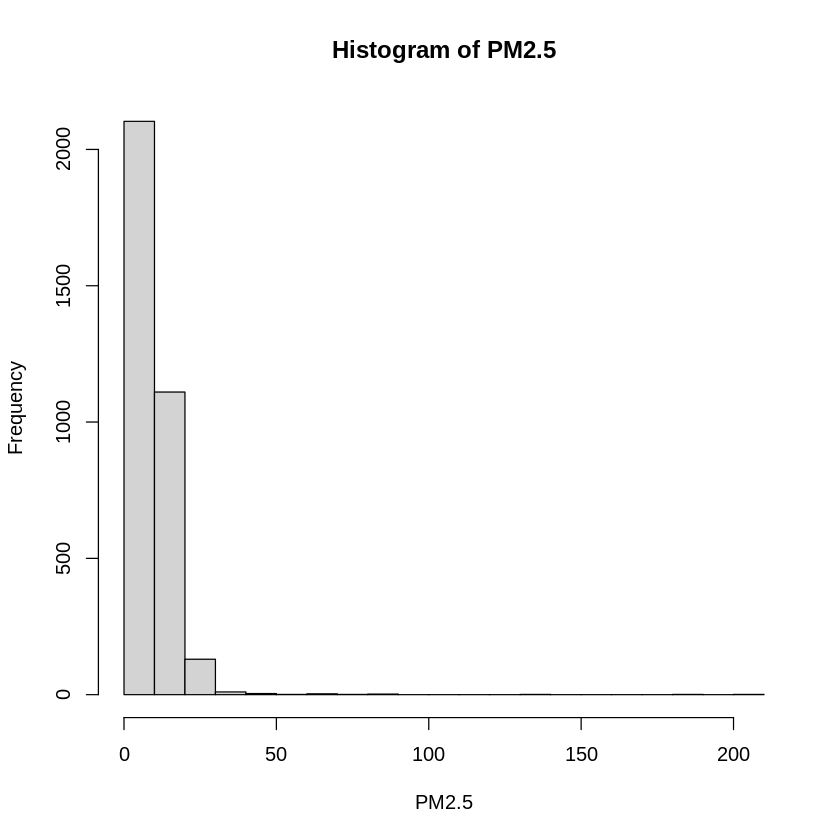

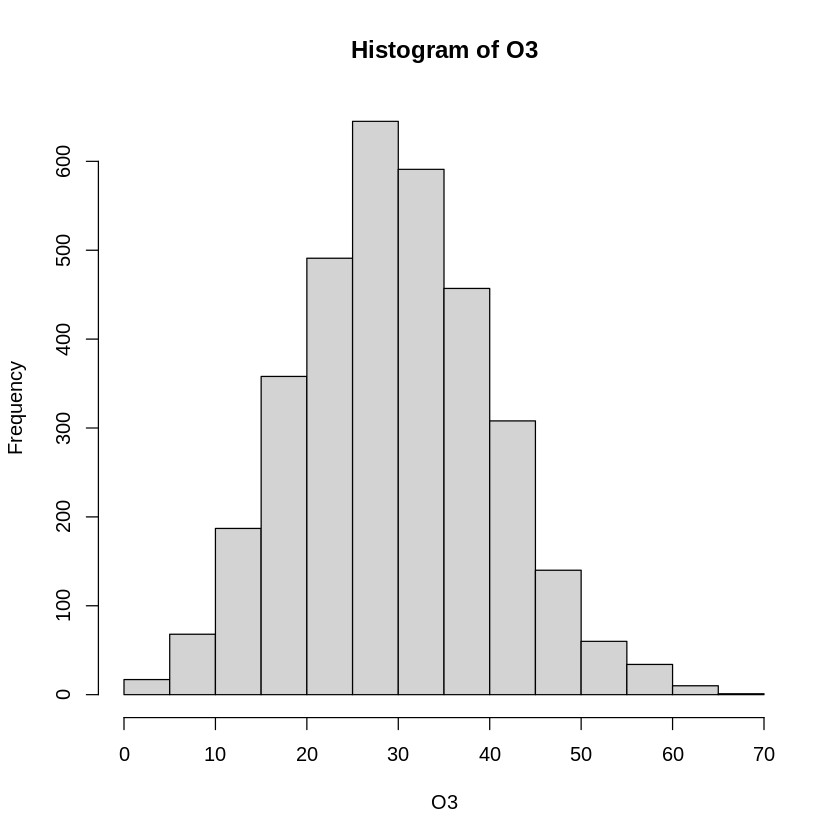

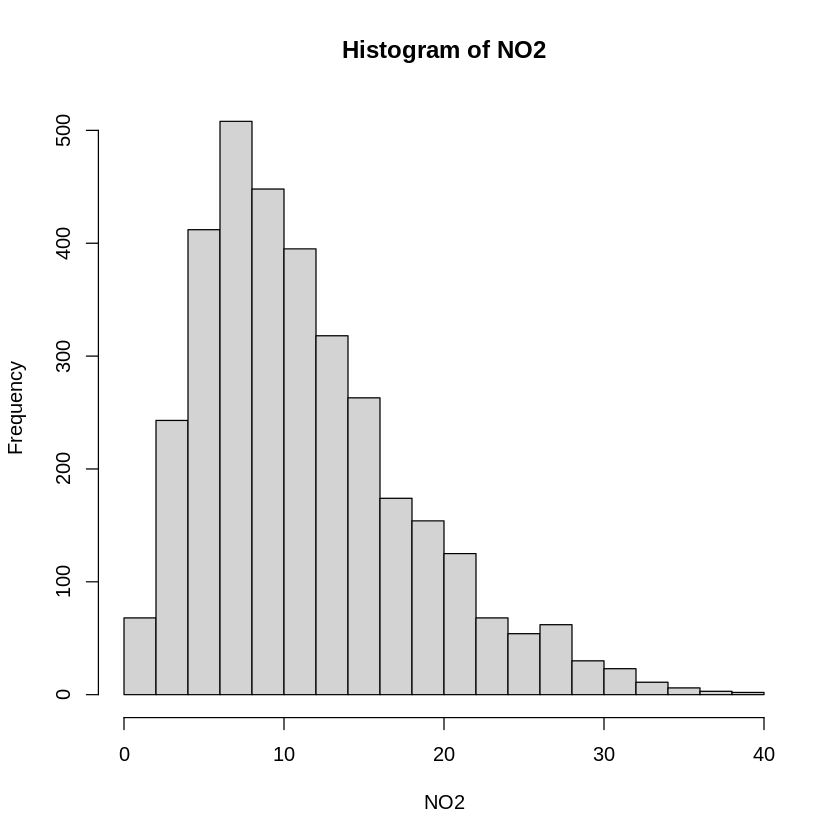

In [49]:
hist(total_df$temperature_2m_mean, main = "Histogram of Temperature", xlab = "Temperature (°F)", breaks = 20)
hist(total_df$PM25, main = "Histogram of PM2.5", xlab = "PM2.5", breaks = 20)
hist(total_df$O3, main = "Histogram of O3", xlab = "O3", breaks = 20)
hist(total_df$NO2, main = "Histogram of NO2", xlab = "NO2", breaks = 20) 

### Bootstrapping

#### PM2.5

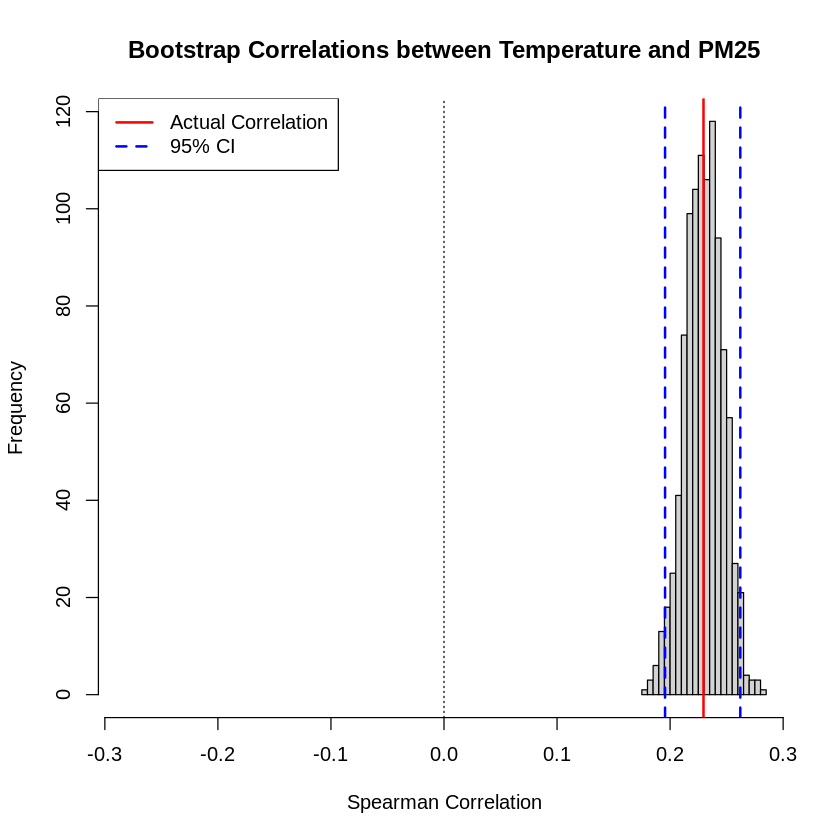

In [50]:

bootstrap <- function(df, pollutant, b){
  bootstrap_correlations <- numeric(b)
  for (i in 1:b){
    sample <- df[sample(nrow(df), replace = TRUE), ]
    bootstrap_correlations[i] <- cor(sample$temperature_2m_mean, sample[[pollutant]], method = "spearman")
  }

  # actual correlation between pollutant and temperature
  actual_correlation <- cor(df$temperature_2m_mean, df[[pollutant]], method = "spearman")

  # 95% confidence interval
  ci <- quantile(bootstrap_correlations, c(0.025, 0.975))

  round(actual_correlation, 3)
  round(ci, 3)
  
  # plot histogram of bootstrap correlations and mark actual correlation and confidence intervals
  m <- max(abs(c(bootstrap_correlations, actual_correlation, ci)))
  hist(bootstrap_correlations, main = paste("Bootstrap Correlations between Temperature and", pollutant), xlab = "Spearman Correlation", breaks = 30, xlim = c(-m, m))
  abline(v = actual_correlation, col = "red", lwd = 2)
  abline(v = ci[1], col = "blue", lwd = 2, lty = 2)
  abline(v = ci[2], col = "blue", lwd = 2, lty = 2)
  abline(v = 0, col = "black", lwd = 1, lty = 3)
  legend("topleft", legend = c("Actual Correlation", "95% CI"), col = c("red", "blue"), lwd = 2, lty = c(1,2))
  }

bootstrap(total_df, "PM25", 1000)

#### O3

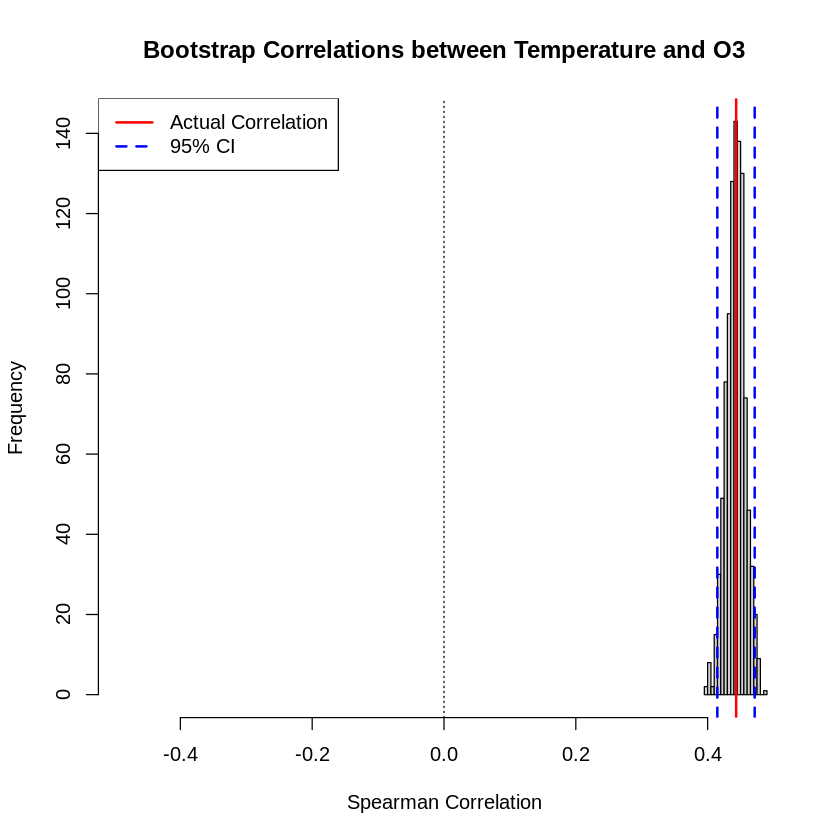

In [51]:
bootstrap(total_df, "O3", 1000)

#### NO2

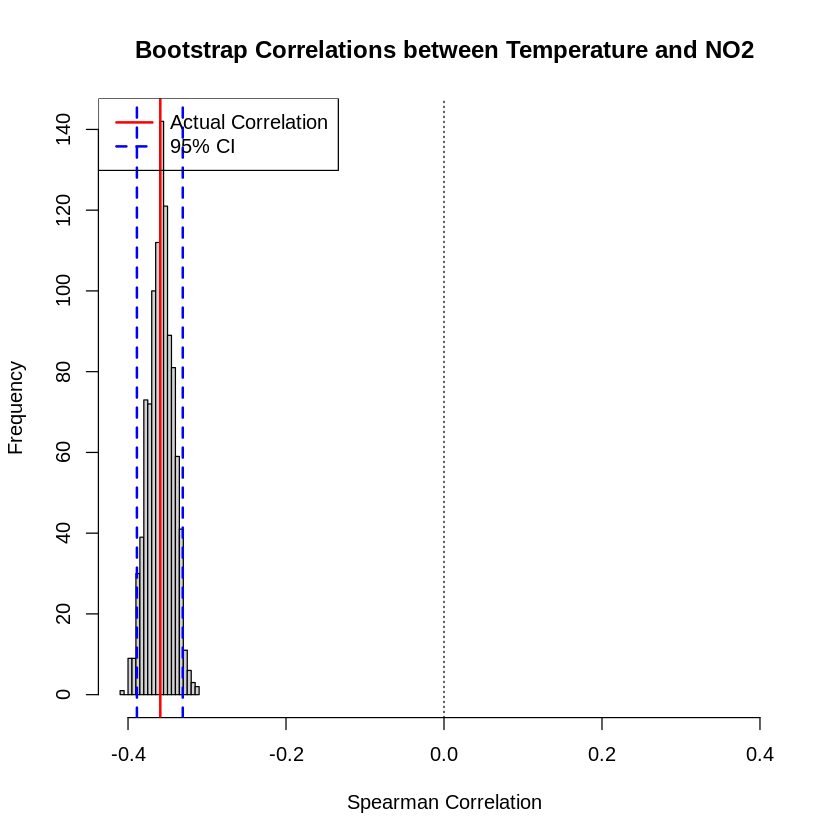

In [52]:
bootstrap(total_df, "NO2", 1000)